In [1]:
import torch
import torch.nn as nn

# 4. Dummy GPT Model

Placeholder model to build high level Decoder LLM

In [2]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,  # Vocabulary size
    "context_length": 1024,  # Context length
    "emb_dim": 768,  # Embedding dimension
    "n_heads": 12,  # Number of attention heads
    "n_layers": 12,  # Number of layers
    "drop_rate": 0.1,  # Dropout rate
    "qkv_bias": False,  # Query-Key-Value bias
}

In [3]:
class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()

    def forward(self, x):
        return x

In [4]:
class DummyGPTModel(nn.Module):

    def __init__(self, cfg: dict):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.size()
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))

        x = tok_embeds + pos_embeds
        x = self.drop(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

## 4.1. Passing Two Text Inputs in DummyGPT Class

In [5]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

In [6]:
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(tokenizer.encode(txt1))
batch.append(tokenizer.encode(txt2))

batch = torch.tensor(batch)

In [7]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


## 4.2. Layer Normalisation

Core idea of layer normalization is to improve the stablity and efficiency of neural network training. It does by adjusting the outputs of a neural network layer to have mean of 0 and variance of 1

This also helps in exploding & vanishing Gradient Problem.

Layer Normalisation is performing Standard Scaler across the features

Batch Normalisation is not used in LLMs. Why?

In [8]:
torch.manual_seed(123)

batch_example = torch.randn(2, 5)
batch_example

tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969],
        [ 0.2093, -0.9724, -0.7550,  0.3239, -0.1085]])

In [9]:
## There's a linear layer and a ReLU activation function
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
out

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)

### 4.2.1. Mean and Variance of Output

In [10]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


### 4.2.2. Applying Layer Norm

In [11]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)

print("Mean after normalization:\n", mean)
print("Variance after normalization:\n", var)

Mean after normalization:
 tensor([[-5.9605e-08],
        [ 1.9868e-08]], grad_fn=<MeanBackward1>)
Variance after normalization:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


### 4.2.3. Creating PyTorch Module for LayerNorm

In [12]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5  # prevents division by zero error
        self.scale = nn.Parameter(
            torch.ones(emb_dim)
        )  # Default Scale & Shift is set to 1 & 0
        self.shift = nn.Parameter(torch.zeros(emb_dim))  # But network can learn them

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        out = norm_x * self.scale + self.shift
        return out

In [13]:
layer_nm = LayerNorm(5)
out_ln = layer_nm(batch_example)

mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, keepdim=True, unbiased=False)
print("Mean after layer normalization:\n", mean)
print("Variance after layer normalization:\n", var)

Mean after layer normalization:
 tensor([[-2.9802e-08],
        [ 0.0000e+00]], grad_fn=<MeanBackward1>)
Variance after layer normalization:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [14]:
out_ln

tensor([[ 0.5528,  1.0693, -0.0223,  0.2656, -1.8654],
        [ 0.9087, -1.3767, -0.9564,  1.1304,  0.2940]], grad_fn=<AddBackward0>)

## 4.3. Implementing a Feed Forward Network with GELU Activations

GeLU stands for Gaussian Error Linear Units which is sort of like a smoother version of ReLU activation function. It offers improved performance for deep learning models

Llama Model uses SwiGLU, which stands for Swish Gates Linear Units

Original Paper, Where $\phi(x)$ is CDF of standard Gaussian  $$GELU(x) = x. \phi(x)$$


However in GPT-2 Model, it is approximated to be

$$GELU(x) = 0.5 . x . (1 + tanh[\sqrt{\frac{2}{\pi})]} . (x + 0.044715 . x^3)$$

### 4.3.1. GeLU Activation

In [15]:
class GELU(nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, x):

        return (
            0.5
            * x
            * (
                1
                + torch.tanh(
                    torch.sqrt(torch.tensor(2.0) / torch.tensor(torch.pi))
                    * (x + 0.044715 * torch.pow(x, 3))
                )
            )
        )

#### 4.3.1.1. Visualisation of GELU

In [16]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

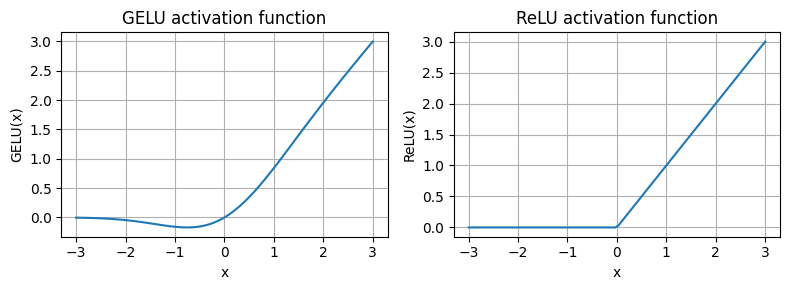

In [18]:
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

- ReLU has a sharp corner at 0, which makes optimization harder in deep networks
- GeLU allows for a small, non-zero output for negative values. this means during training neurons that receive negative input can still contribute to the learning process

### 4.3.2. Feedforward Layer

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [22]:
ffn = FeedForward(GPT_CONFIG_124M)

In [23]:
x = torch.rand(2, 3, 768)  ## 2 batch size, 3 sequence length, 768 embedding dimension
ffn(x).shape

torch.Size([2, 3, 768])

## 4.4. Adding Shortcut or Residual Block

ResNET paper introduced concept of Residual Block in training deeper CNNs, in which input is added back after weight transformation, otherwise gradients become progressively smaller as they propagate backward through the layer (Vanishing Gradient)

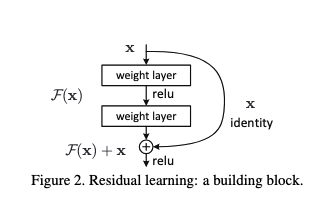

In [28]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList(
            [
                nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
                nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
                nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
                nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
                nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU()),
            ]
        )

    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

In [30]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1.0, 0.0, -1.0]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=False)

In [32]:
def print_gradients(model, x):
    output = model(x)
    target = torch.tensor([[0.0]])

    loss = nn.MSELoss()
    loss = loss(output, target)

    loss.backward()

    for name, param in model.named_parameters():
        if "weight" in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [33]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041071094573
layers.3.0.weight has gradient mean of 0.0013988735154271126
layers.4.0.weight has gradient mean of 0.005049645435065031


In [34]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=True)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576
